In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [159]:
wildfires = pd.read_csv('Historical_wildfires.csv')
wildfires['Date'] = pd.to_datetime(wildfires['Date'])
wildfires = pd.pivot(wildfires, index = 'Date', columns = 'Region', values = 'Estimated_fire_area')


# Instantiating another dataframe with a daterange and merge to find the missing date.
dummy = pd.DataFrame(index = pd.date_range(start = '2005-01-01', end = '2020-10-31'))
# dummy['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')


# 2020-03-06 have missing values for all 7 states.
wildfires_merge = pd.merge(wildfires, dummy, how = 'outer', left_index =True, right_index=True)
wildfires_merge

wildfires = wildfires_merge.copy(deep=True)
wildfires.fillna(0, inplace=True)
wildfires

,NSW,NT,QL,SA,TA,VI,WA
2005-01-01,0.00000,4.945000,38.831579,0.0,0.0,0.0,36.382500
2005-01-02,0.00000,1.320000,64.464286,0.0,0.0,2.8,148.106471
2005-01-03,0.00000,88.740000,47.386585,0.0,0.0,1.0,60.632258
2005-01-04,8.68000,0.000000,30.100000,0.0,0.0,0.0,86.374167
2005-01-05,16.61125,0.000000,4.000000,0.0,0.0,0.0,31.378947
...,...,...,...,...,...,...,...
2020-10-27,1.21000,12.750000,78.670769,0.0,0.0,0.0,32.970000
2020-10-28,3.00000,144.990566,119.608649,0.0,0.0,2.0,20.840625
2020-10-29,0.00000,53.462326,249.090625,0.0,0.0,0.0,136.083077
2020-10-30,1.32000,171.325280,282.538983,0.0,0.0,2.0,42.397895


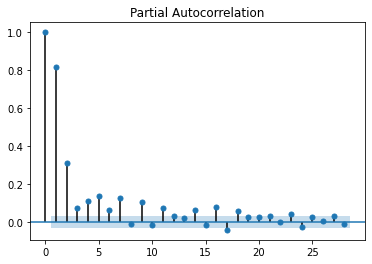

In [160]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(np.log1p(wildfires[:'2015']['QL']), lags = 28, alpha = 0.05, method = 'ols');

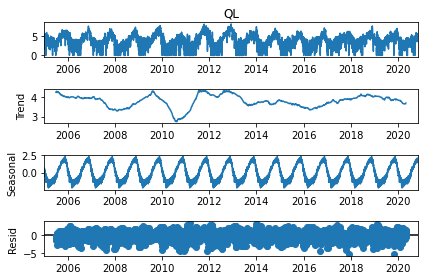

In [190]:
result = seasonal_decompose(np.log1p(wildfires['QL']), model = 'additive', period = 365)
result.plot();

In [193]:
adfuller(wildfires['QL'])

(-6.221917236576774,
 5.1984141461888144e-08,
 31,
 5751,
 {'1%': -3.4314875797597644,
  '5%': -2.8620427016919505,
  '10%': -2.5670375862348798},
 72274.317226506)

In [192]:
adfuller(np.log1p(wildfires['QL']))

(-5.200458768812008,
 8.773142280676678e-06,
 33,
 5749,
 {'1%': -3.431487975685421,
  '5%': -2.8620428766198245,
  '10%': -2.5670376793540988},
 15271.115823256372)

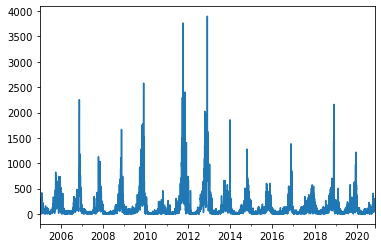

In [166]:
wildfires['QL'].plot()

In [197]:
_queens_log = wildfires[['QL']].copy(deep=True)
_queens_log

,QL
2005-01-01,38.831579
2005-01-02,64.464286
2005-01-03,47.386585
2005-01-04,30.100000
2005-01-05,4.000000
...,...
2020-10-27,78.670769
2020-10-28,119.608649
2020-10-29,249.090625
2020-10-30,282.538983


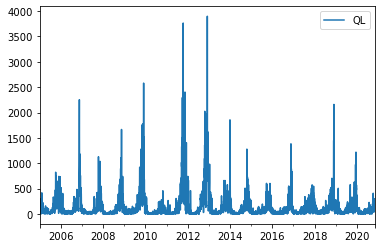

In [198]:
_queens_log.plot()

In [210]:
import datetime
# datetime.datetime.timestamp(pd.to_datetime('2020-01-15')) 
# _jan = (datetime.datetime.timestamp(pd.to_datetime('2020-01-15')) - datetime.datetime.timestamp(pd.to_datetime('2005-01-15'))) / 15
# _yearly = _queens_log.index.map(datetime.datetime.timestamp) % _jan
_day_of_year = [15.5, 45, 75.5, 106, 136.5, 167, 197.5, 228.5, 259, 289.5, 320, 350.5]
for i, x in zip(range(1,13), _day_of_year):
    _queens_log['month_{}'.format(i)] = np.where(_queens_log.index.month == i, 1, 0)

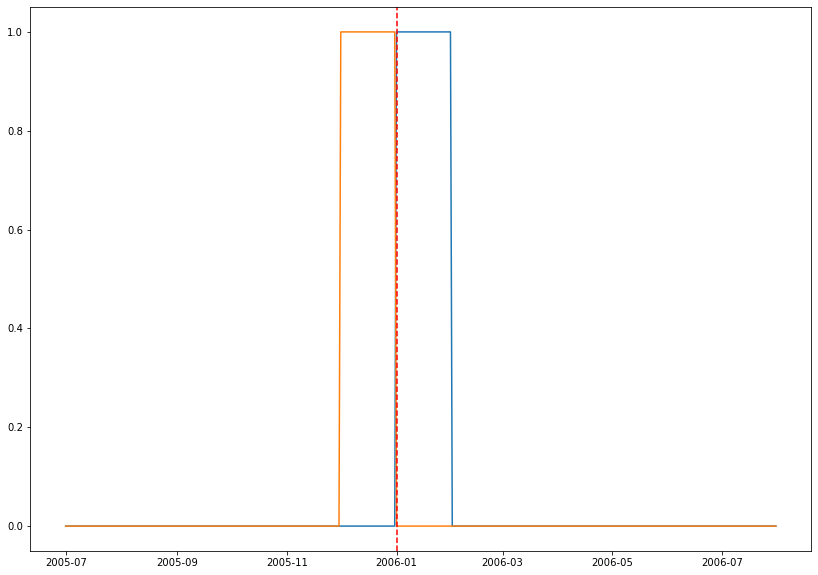

In [212]:
plt.figure(figsize=(14,10))
plt.plot(_queens_log['2005-7':'2006-7']['month_1'])
# plt.plot(_queens_log[:'2006-12']['month_2'])
# plt.plot(_queens_log[:'2006-12']['month_11'])
plt.plot(_queens_log['2005-7':'2006-7']['month_12'])
plt.axvline(x=pd.to_datetime('2006-01-01'), color = 'r', linestyle = '--');


In [203]:
train = _queens_log[:'2019-10-31']
test = _queens_log['2019-11-01':'2020-02-29']
train

,QL,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-01-01,38.831579,1,0,0,0,0,0,0,0,0,0,0,0
2005-01-02,64.464286,1,0,0,0,0,0,0,0,0,0,0,0
2005-01-03,47.386585,1,0,0,0,0,0,0,0,0,0,0,0
2005-01-04,30.100000,1,0,0,0,0,0,0,0,0,0,0,0
2005-01-05,4.000000,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,50.888889,0,0,0,0,0,0,0,0,0,1,0,0
2019-10-28,87.723636,0,0,0,0,0,0,0,0,0,1,0,0
2019-10-29,11.215556,0,0,0,0,0,0,0,0,0,1,0,0
2019-10-30,0.000000,0,0,0,0,0,0,0,0,0,1,0,0


In [204]:
exog_train = train.iloc[:,1:]
exog_test = test.iloc[:, 1:]

model_SARIMAX = SARIMAX(train['QL'], order = (2,0,0), trend = 'n', freq = 'D', exog = exog_train,
                       enforce_stationarity=False, enforce_invertibility = False)

results = model_SARIMAX.fit(maxiter=1000)

pred = results.predict('2019-11-01', '2020-02-29', exog= exog_test)

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


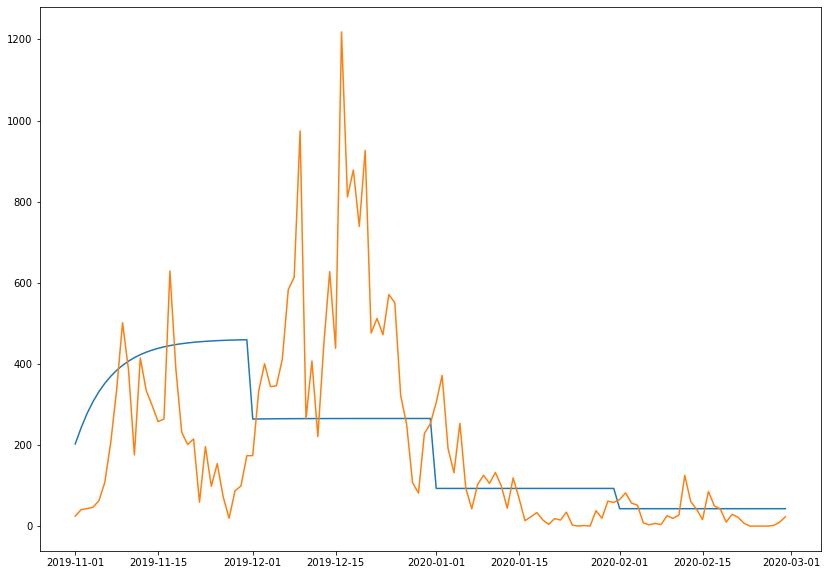

In [206]:
plt.figure(figsize=(14,10))
plt.plot(pred)
plt.plot(test['QL'])


In [232]:
_list = []
for i in range(15):
    _list.append(np.array(_day_of_year) + (i * 365.2425))
    
_array = np.array(_list)

_index = np.array(range(1, len(_queens_log) + 1))

for i,month in zip(_array.T, range(1,13)):
    _list = []
    _index = np.array(range(1, len(_queens_log) + 1))
    
    for each in i:
        _list.append(np.exp(-1/(305)*(_index - each)**2))
    
    _list = np.array(_list)
    _max = _list.max(axis = 0)
    _queens_log['month_{}'.format(month)] = _max

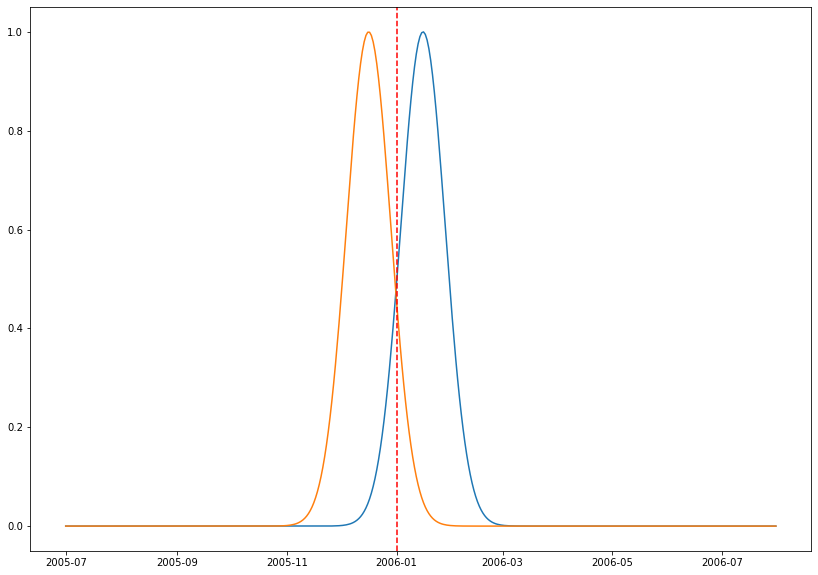

In [233]:
plt.figure(figsize=(14,10))
plt.plot(_queens_log['2005-7':'2006-7']['month_1'])
# plt.plot(_queens_log[:'2006-12']['month_2'])
# plt.plot(_queens_log[:'2006-12']['month_11'])
plt.plot(_queens_log['2005-7':'2006-7']['month_12'])
plt.axvline(x=pd.to_datetime('2006-01-01'), color = 'r', linestyle = '--')


In [234]:
train = _queens_log[:'2019-10-31']
test = _queens_log['2019-11-01':'2020-02-29']

In [235]:
train

,QL,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-01-01,38.831579,5.019051e-01,1.751048e-03,1.249995e-08,2.001347e-16,7.186876e-27,5.788439e-40,1.045650e-55,2.011084e-74,1.653610e-95,3.049578e-119,1.261392e-145,1.170210e-174
2005-01-02,64.464286,5.501628e-01,2.329049e-03,2.030710e-08,3.971192e-16,1.741797e-26,1.713475e-39,3.780609e-55,8.910216e-74,8.948496e-95,2.015652e-118,1.018321e-144,1.153871e-173
2005-01-03,47.386585,5.991190e-01,3.077596e-03,3.277478e-08,7.828375e-16,4.193794e-26,5.039022e-39,1.357967e-54,3.921917e-73,4.810820e-94,1.323560e-117,8.167168e-144,1.130325e-172
2005-01-04,30.100000,6.481672e-01,4.040142e-03,5.255133e-08,1.533114e-15,1.003157e-25,1.472200e-38,4.845835e-54,1.714987e-72,2.569451e-93,8.634230e-117,6.507446e-143,1.100021e-171
2005-01-05,4.000000,6.966477e-01,5.269069e-03,8.371048e-08,2.982837e-15,2.383871e-25,4.273067e-38,1.717910e-53,7.450326e-72,1.363370e-92,5.595720e-116,5.151121e-142,1.063534e-170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,50.888889,1.168601e-115,4.971256e-93,3.066036e-72,4.241233e-54,1.315863e-38,9.156567e-26,1.429086e-15,6.321083e-08,4.490504e-03,7.154881e-01,2.556898e-01,2.049406e-04
2019-10-28,87.723636,1.807835e-116,9.331894e-94,7.029749e-73,1.187719e-54,4.500812e-39,3.825357e-26,7.292167e-16,3.952505e-08,3.429533e-03,6.674230e-01,2.913205e-01,2.851968e-04
2019-10-29,11.215556,2.778455e-117,1.740306e-94,1.601233e-73,3.304358e-55,1.529408e-39,1.587681e-26,3.696638e-16,2.455305e-08,2.602118e-03,6.185176e-01,3.297470e-01,3.942877e-04
2019-10-30,0.000000,4.242290e-118,3.224286e-95,3.623443e-74,9.132989e-56,5.163071e-40,6.546466e-27,1.861699e-16,1.515273e-08,1.961422e-03,5.694494e-01,3.708026e-01,5.415445e-04


In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [237]:
exog_train = train.iloc[:,1:]
exog_test = test.iloc[:, 1:]

model_SARIMAX = SARIMAX(train['QL'], order = (2,0,0), trend = 'n', freq = 'D', exog = exog_train,
                       enforce_stationarity=False, enforce_invertibility = False)

results = model_SARIMAX.fit(maxiter=1000)

pred = results.predict('2019-11-01', '2020-02-29', exog= exog_test)

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [238]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     QL   No. Observations:                 5417
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -34286.219
Date:                Fri, 11 Dec 2020   AIC                          68602.437
Time:                        09:15:13   BIC                          68701.391
Sample:                    01-01-2005   HQIC                         68636.979
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_1       71.3194     44.778      1.593      0.111     -16.445     159.084
month_2       38.4352     91.435      0.420      0.674    -140.774     217.645
month_3       15.6258    229.933      0.068      0.946    -435.034     466.286
month_4       17.5252    261.315      0.067      0.947    -494.643     529.693
month_5       23.5608    213.998      0.110      0.912    -395.867     442.988
month_6       30.9694    149.161      0.208      0.836    -261.381     323.320
month_7       52.5057    109.883      0.478      0.633    -162.861     267.872
month_8       96.5118     82.218      1.174      0.240     -64.632     257.655
month_9      217.8243     43.783      4.975      0.000     132.011     303.637
month_10     331.2024     25.613     12.931      0.000     281.001     381.404
month_11     511.7395     20.341     25.158      0.000     471.872     551.607
month_12     242.8595     28.128      8.634      0.000     187.731     297.988
ar.L1          0.6165      0.004    174.268      0.000       0.610       0.623
ar.L2          0.1862      0.004     42.690      0.000       0.178       0.195
sigma2       1.85e+04     80.139    230.852      0.000    1.83e+04    1.87e+04
===================================================================================
Ljung-Box (Q):                      481.96   Jarque-Bera (JB):            865112.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             3.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        64.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

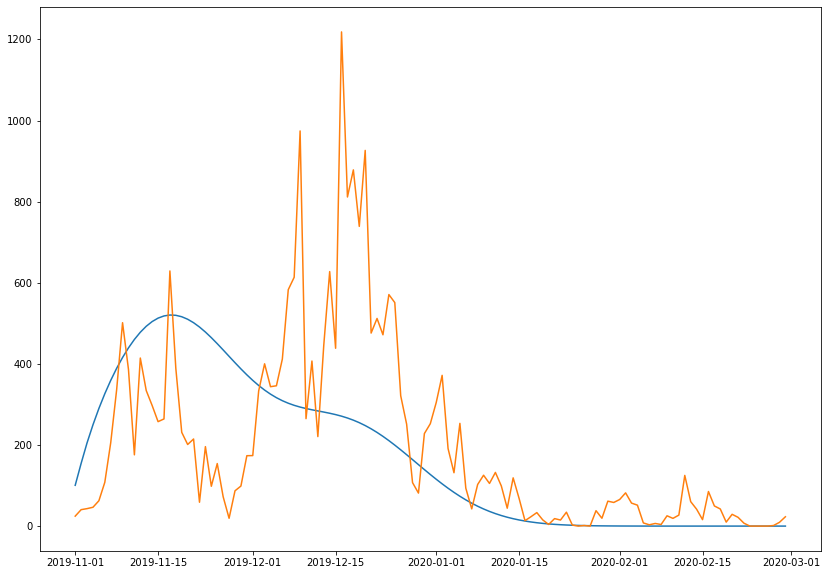

In [239]:
plt.figure(figsize=(14,10))
plt.plot(pred)
plt.plot(test['QL'])
